In [2]:
import os
import json
import tempfile

import wandb
from omegaconf import OmegaConf
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from foundational_ssm.models import SSMFoundationalDecoder, SSMDownstreamDecoder, discretize_zoh
from foundational_ssm.utils import load_model_and_state_from_checkpoint_wandb
from typing import Any, BinaryIO

%load_ext autoreload
%autoreload 2

In [3]:
def get_discretized_ssm_parameters(ssm):
    Lambda = ssm.Lambda_re + 1j * ssm.Lambda_im
    B_tilde = ssm.B[..., 0] + 1j * ssm.B[..., 1]
    C_tilde = ssm.C[..., 0] + 1j * ssm.C[..., 1]

    Delta = ssm.step_rescale * jnp.exp(ssm.log_step[:, 0])
    Lambda_bar, B_bar = discretize_zoh(Lambda, B_tilde, Delta)
    Lambda_bar = jnp.concat([Lambda_bar, jnp.conj(Lambda_bar)])
    # print(B_tilde, B_bar)

    return Lambda_bar, B_bar, C_tilde, Delta

In [4]:
def plot_matrix_sv_pre_post_training(models, 
                                     colormap = 'viridis'):
    
    num_blocks = len(list(models.values())[0].ssm_blocks)
    
    fig, axs = plt.subplots(num_blocks, 5, figsize=(12, 3*num_blocks))
    axs = axs.flatten()
    
    cmap = plt.get_cmap(colormap)
    num_train_statuses = len(list(models.keys()))
    colors = [cmap(i / (num_train_statuses - 1)) for i in range(num_train_statuses)]
    
    for j, (train_status, m) in enumerate(models.items()):
        color = colors[j]

        for i, layer in enumerate(m.ssm_blocks):
            
            Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(layer.ssm)
            
            # Plot singular values of B 
            b_sv = jnp.linalg.svd(B_bar, compute_uv=False)
            axs[i*5].hist(np.abs(b_sv), alpha=0.7, label=f'{train_status}', 
                            density=True, color=color, edgecolor='white', linewidth=0.5)
            axs[i*5].set_title(f'Layer {i}' +r' $\bar{B}$')

        
            c_sv = jnp.linalg.svd(C_tilde, compute_uv=False)
            axs[1 + i*5].hist(np.abs(c_sv), alpha=0.7, label=f'{train_status}', 
                        density=True, color=color, edgecolor='white', linewidth=0.5)
            axs[1 + i*5].set_title(f'Layer {i}' +r' $\bar{C}$')
            
            glu_w1 = layer.glu.w1.weight
            glu_w1_sv = jnp.linalg.svd(glu_w1, compute_uv=False)
            axs[2 + i*5].hist(glu_w1_sv, alpha=0.7, label=f'{train_status}', 
                        density=True, color=color, edgecolor='white', linewidth=0.5)
            axs[2 + i*5].set_title(f'Layer {i} GLU ' + r'$W_1$')
            
            glu_w2 = layer.glu.w2.weight
            axs[3 + i*5].hist(glu_w1_sv, alpha=0.7, label=f'{train_status}', 
                        density=True, color=color, edgecolor='white', linewidth=0.5)
            axs[3 + i*5].set_title(f'Layer {i} GLU ' + r'$W_2$')

        if hasattr(m, 'encoder'):
            encoder_sv = jnp.linalg.svd(m.encoder.weight, compute_uv=False)
            axs[4].hist(encoder_sv, alpha=0.7, label=f'{train_status}', 
                        density=True, color=color, edgecolor='white', linewidth=0.5)
            axs[4].set_title('Encoder')
        else:
            axs[4].axis('off')

        decoder_sv = jnp.linalg.svd(m.decoder.weight, compute_uv=False)
        axs[-1].hist(decoder_sv, alpha=0.7, label=f'{train_status}', 
                    density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[-1].set_title('Decoder')

    for ax in axs:
        ax.set_xlabel('Singular Value')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)

    axs[0].legend()    
    fig.suptitle("Singular Values of Matrices Pre and Post Training")
    fig.tight_layout()
    fig.show()

def plot_A_matrix_pre_post_training(models, colormap='viridis'):
    fig, axs = plt.subplots(1, 2, figsize=(7,4), sharey='all')
    axs = axs.flatten()
    theta = np.linspace(0, 2 * np.pi, 100)
    
    cmap = plt.get_cmap(colormap)
    num_train_statuses = len(list(models.keys()))
    colors = [cmap(i / (num_train_statuses - 1)) for i in range(num_train_statuses)]
    
    num_blocks = len(list(models.values())[0].ssm_blocks)

    for i in range(num_blocks):
        ax = axs[i]
        for j, (train_status, m) in enumerate(models.items()):
            color = colors[j]
            ssm_block = m.ssm_blocks[i]
            Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(ssm_block.ssm)
            ax.plot(Lambda_bar.real, Lambda_bar.imag, 'o', label=train_status, color=color, markersize=3)
            
        ax.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle', alpha=0.3)
        ax.set_title(f'Layer {i}' +r' $\bar{A}$' + ' Eigenvalues')
        ax.set_xlabel('Real part')
        ax.grid()
        ax.set_box_aspect(1)

    # draw unit circle
    axs[0].legend()
    axs[0].set_ylabel('Imaginary part')
    fig.tight_layout()
    fig.suptitle('Eigenvalues of Discretized A without Weight Decay')
    fig.show()

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


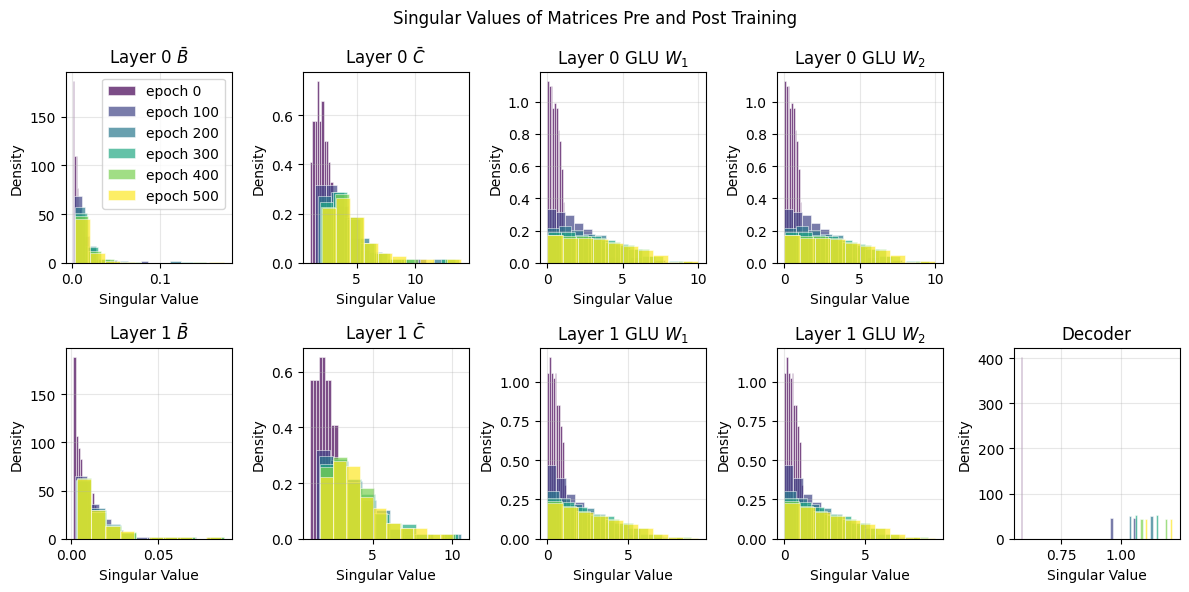

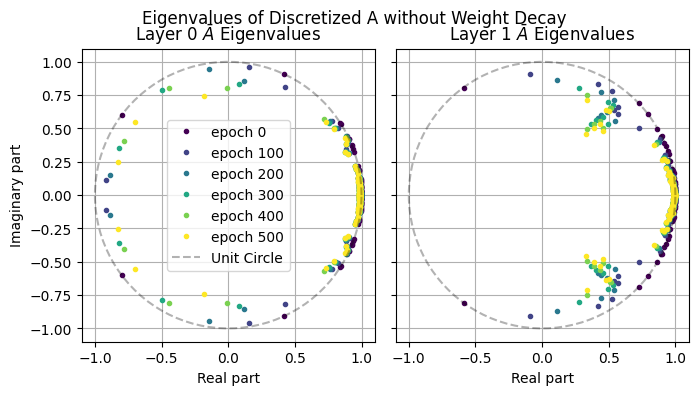

In [41]:
# discretized_parameters = {'fresh': {}, 'trained': {}}
model_cls = SSMFoundationalDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_normalized_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    

plot_matrix_sv_pre_post_training(models) 
plot_A_matrix_pre_post_training(models)

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


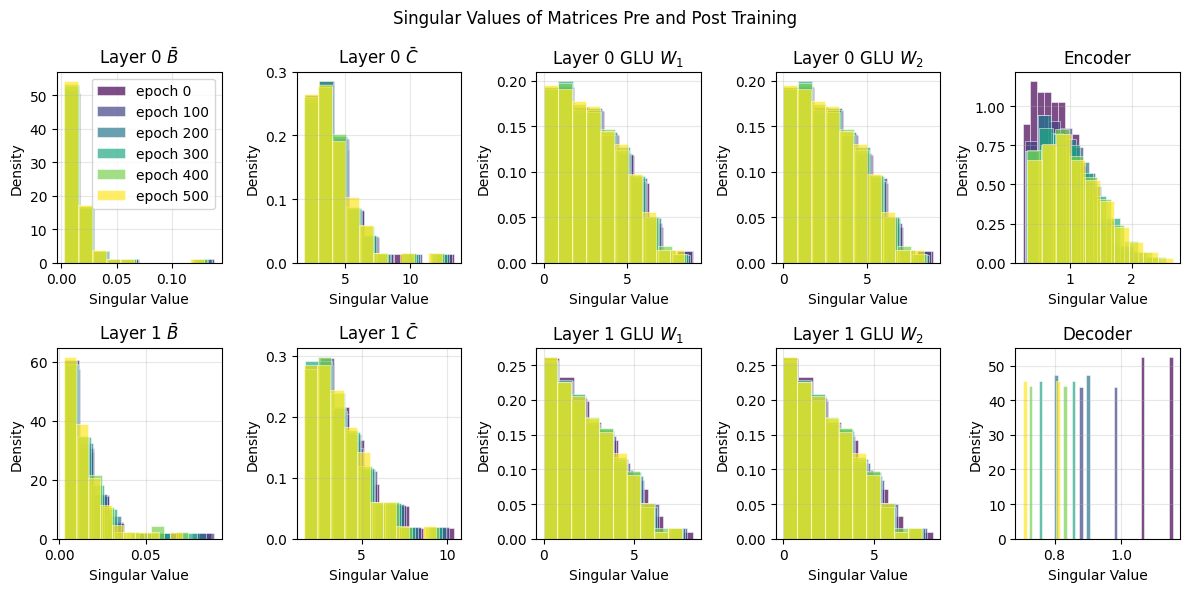

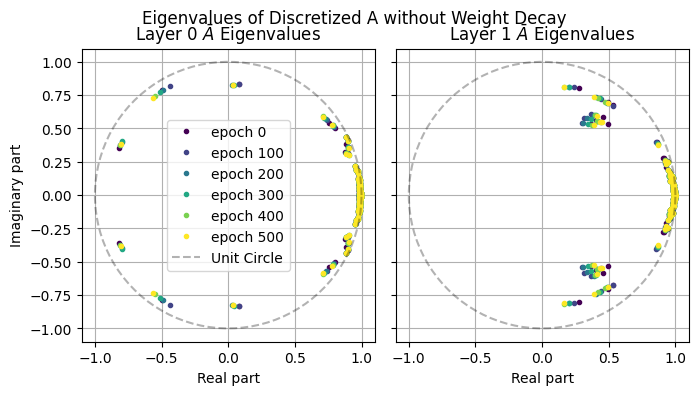

In [42]:
# discretized_parameters = {'fresh': {}, 'trained': {}}
model_cls = SSMDownstreamDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_rtt/l2_reaching_normalized_all_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    

plot_matrix_sv_pre_post_training(models) 
plot_A_matrix_pre_post_training(models)

# Downstream, From Scratch

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'training.from_scratch': True}

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


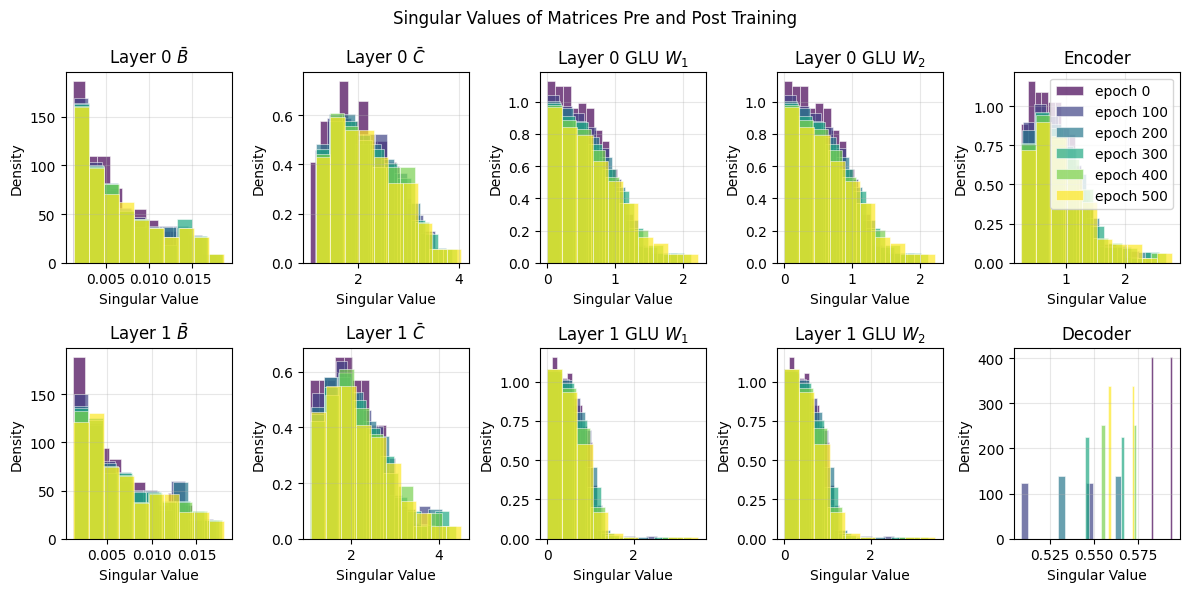

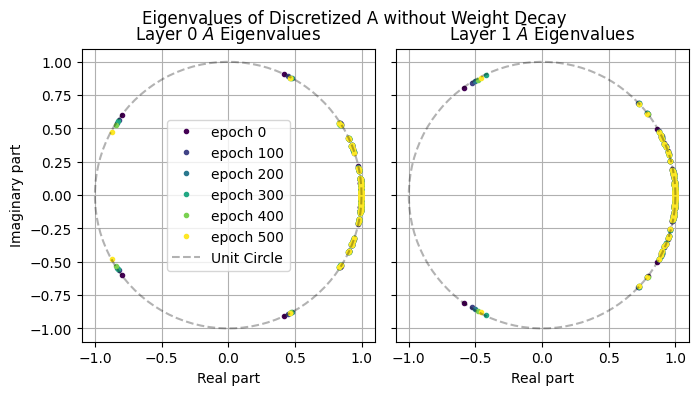

In [32]:
# discretized_parameters = {'fresh': {}, 'trained': {}}
model_cls = SSMDownstreamDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_rtt/l2_scratch_all_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    

plot_matrix_sv_pre_post_training(models) 
plot_A_matrix_pre_post_training(models)

# From Scratch PM T CO

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 72, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_downstream_pm', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_checkpoints': True}, 'input_dim': 625, 'optimizer': {'lr': 0.004, 'mode': 'all', 'weight_decay': 0.03}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 64, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_args': {'recording_id': 'perich_miller_population_2018/t_20130819_center_out_reaching'}, 'optimizer.lr': 0.004, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 72, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_downstream_pm', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_checkpoints': True}, 'input_dim': 625, 'optimizer': {'lr': 0.004, 'mode': 'all', 'weight_decay': 0.03}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 64, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_args': {'recording_id': 'perich_miller_population_2018/t_20130819_center_out_reaching'}, 'optimizer.lr': 0.004, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 72, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_downstream_pm', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_checkpoints': True}, 'input_dim': 625, 'optimizer': {'lr': 0.004, 'mode': 'all', 'weight_decay': 0.03}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 64, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_args': {'recording_id': 'perich_miller_population_2018/t_20130819_center_out_reaching'}, 'optimizer.lr': 0.004, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 72, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_downstream_pm', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_checkpoints': True}, 'input_dim': 625, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.03}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 64, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_args': {'recording_id': 'perich_miller_population_2018/t_20130819_center_out_reaching'}, 'optimizer.lr': 0.002, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 1, 'min_window_length': 1}, 'dataloader_args': {'batch_size

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 72, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_downstream_pm', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_checkpoints': True}, 'input_dim': 625, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.03}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 64, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_args': {'recording_id': 'perich_miller_population_2018/t_20130819_center_out_reaching'}, 'optimizer.lr': 0.002, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 1, 'min_window_length': 1}, 'dataloader_args': {'batch_size

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 72, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_downstream_pm', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_checkpoints': True}, 'input_dim': 625, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.03}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 64, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_args': {'recording_id': 'perich_miller_population_2018/t_20130819_center_out_reaching'}, 'optimizer.lr': 0.002, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 1, 'min_window_length': 1}, 'dataloader_args': {'batch_size

wandb:   3 of 3 files downloaded.  


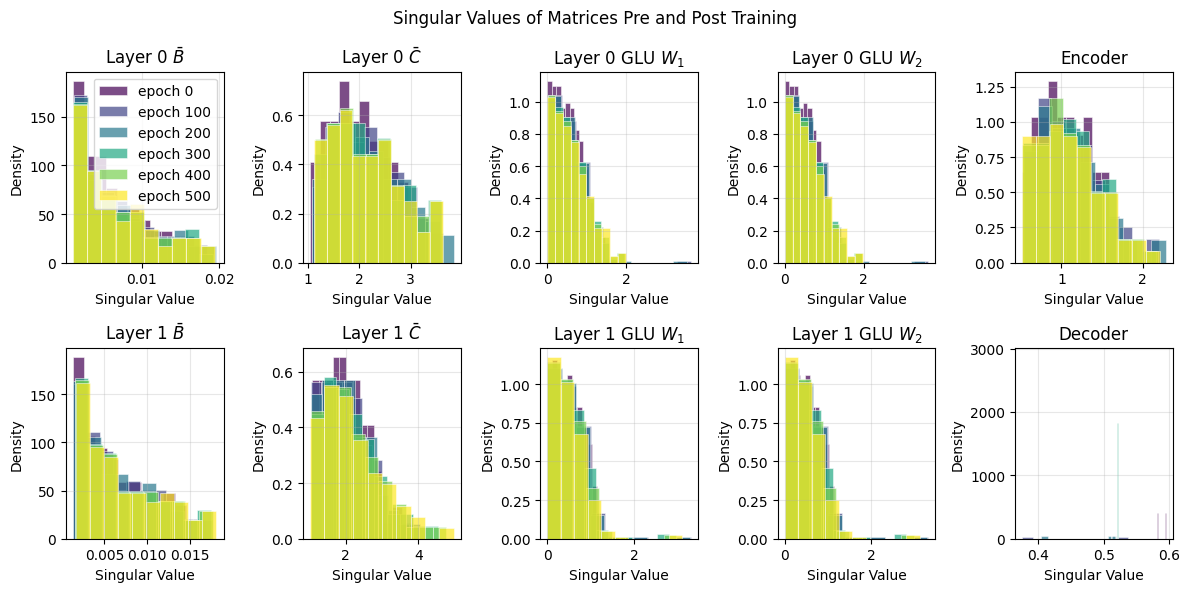

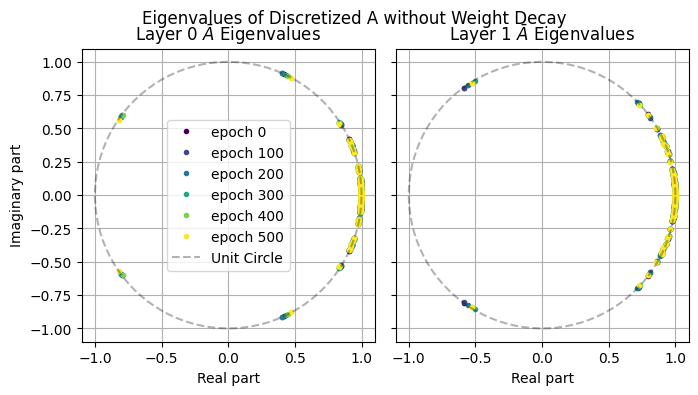

In [5]:
# discretized_parameters = {'fresh': {}, 'trained': {}}
model_cls = SSMDownstreamDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_pm_sweep/l2_h256_p128_all_t_20130819_center_out_reaching_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    

plot_matrix_sv_pre_post_training(models) 
plot_A_matrix_pre_post_training(models)

# MuP-SSM

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


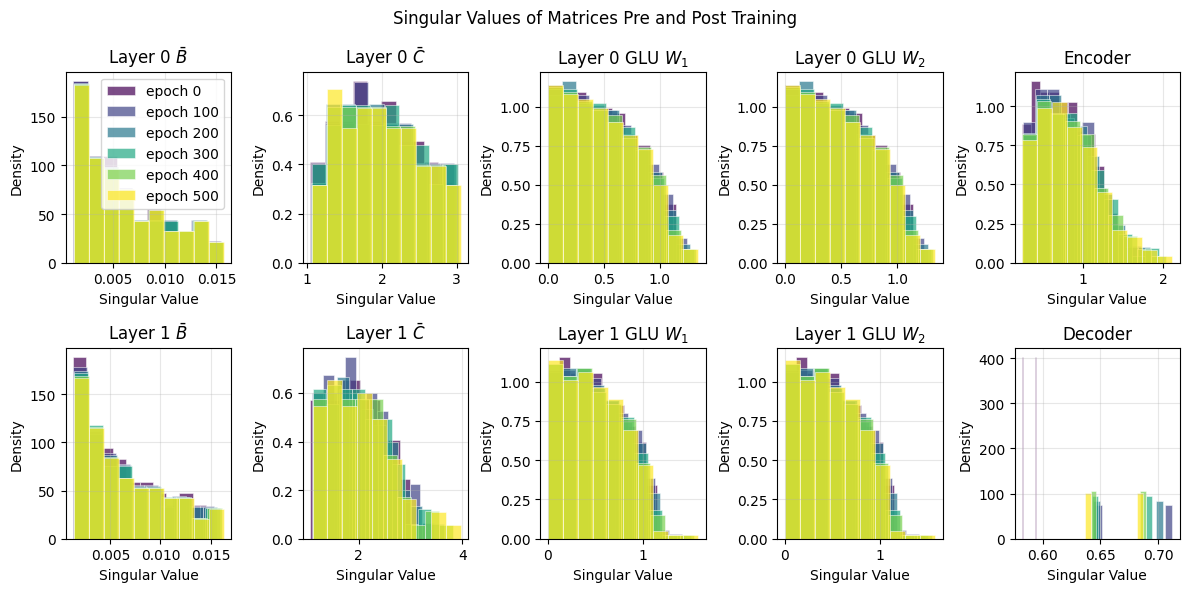

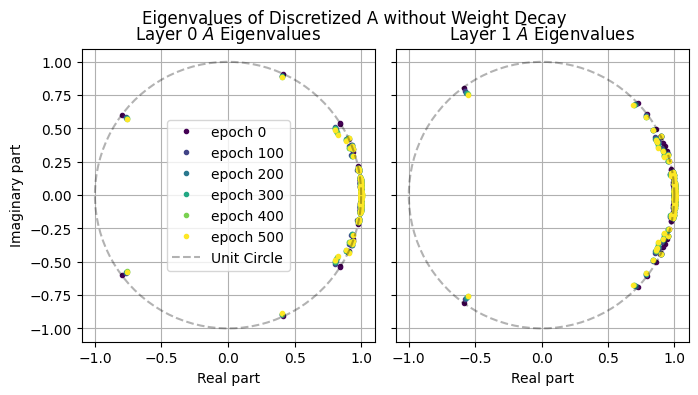

In [6]:

# discretized_parameters = {'fresh': {}, 'trained': {}}
model_cls = SSMDownstreamDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_rtt/l2_h256_p128_muP_SSM_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    

plot_matrix_sv_pre_post_training(models) 
plot_A_matrix_pre_post_training(models)

## Compressed comparison: singular value trajectories by epoch

Instead of per-epoch histograms, we summarize each matrix's singular values by percentiles (e.g., median and 90th) over epochs and overlay four model configurations.
- Rows: blocks (0, 1)
- Columns: matrices (B̄, C̄, GLU W1, GLU W2)
- Lines: model configurations (colors) with median (solid) and 90th percentile (dashed)
This reduces 5×4 pages to a readable 2×4 grid while preserving trends. Decoder is omitted.

In [ ]:
from dataclasses import dataclass
from typing import List, Dict, Tuple, Any

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from foundational_ssm.models.decoders import SSMFoundationalDecoder, SSMDownstreamDecoder
from foundational_ssm.utils.wandb_utils_jax import load_model_and_state_from_checkpoint_wandb
import wandb

@dataclass
class ModelConfig:
    label: str
    artifact_prefix: str  # e.g., 'melinajingting-ucl/foundational_ssm_pretrain/<artifact_name>'
    model_cls: Any        # SSMFoundationalDecoder or SSMDownstreamDecoder

# TODO: Edit these four configs to point to the exact artifact names in W&B, and adjust epochs below if needed.
FOUR_CONFIGS = [
    ModelConfig("pretrain", "melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint", SSMFoundationalDecoder),
    ModelConfig("downstream_all", "melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_1Swindow_checkpoint", SSMFoundationalDecoder),
    ModelConfig("downstream_scratch", "melinajingting-ucl/foundational_ssm_pretrain/l2_no_context_reaching_checkpoint", SSMFoundationalDecoder),
    ModelConfig("pm_center_out_scratch", "melinajingting-ucl/foundational_ssm_pretrain/l2_no_glu_reaching_checkpoint", SSMFoundationalDecoder),
]

# List of epoch aliases to try (aliases must exist on the artifact)
EPOCHS = [0, 100, 200, 300, 400, 500]
MATRIX_NAMES = ["B_bar", "C_bar", "GLU_W1", "GLU_W2"]  # omit decoder
PCTS = [50, 90]  # median and 90th


def list_artifact_aliases(artifact_full_prefix: str) -> List[str]:
    """Return available aliases for the given artifact (before the colon)."""
    api = wandb.Api()
    art = api.artifact(artifact_full_prefix, type="checkpoint")
    return [a for a in art.aliases]


def extract_matrix_svs(block) -> Dict[str, np.ndarray]:
    # Discretized B and C
    Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(block.ssm)
    out: Dict[str, np.ndarray] = {}
    try:
        out["B_bar"] = np.asarray(jnp.linalg.svd(B_bar, compute_uv=False))
    except Exception:
        out["B_bar"] = np.array([])
    try:
        out["C_bar"] = np.asarray(jnp.linalg.svd(C_tilde, compute_uv=False))
    except Exception:
        out["C_bar"] = np.array([])
    # GLU weights (if GLU present)
    if hasattr(block.glu, "w1") and hasattr(block.glu, "w2"):
        w1 = jnp.asarray(block.glu.w1.weight)
        w2 = jnp.asarray(block.glu.w2.weight)
        try:
            out["GLU_W1"] = np.asarray(jnp.linalg.svd(w1, compute_uv=False))
        except Exception:
            out["GLU_W1"] = np.array([])
        try:
            out["GLU_W2"] = np.asarray(jnp.linalg.svd(w2, compute_uv=False))
        except Exception:
            out["GLU_W2"] = np.array([])
    else:
        out["GLU_W1"] = np.array([])
        out["GLU_W2"] = np.array([])
    return out


def summarize_config_over_epochs(cfg: ModelConfig, epochs=EPOCHS, alias_fmt: str = "epoch_{epoch}") -> Dict[int, Dict[int, Dict[str, Dict[str, float]]]]:
    """Return nested dict: block -> epoch -> matrix -> {'p50': val, 'p90': val}
    alias_fmt controls alias naming (e.g., 'epoch_{epoch}' or 'v{epoch_idx}').
    """
    summary: Dict[int, Dict[int, Dict[str, Dict[str, float]]]] = {}
    for epoch in epochs:
        alias = alias_fmt.format(epoch=epoch)
        artifact_full = f"{cfg.artifact_prefix}:{alias}"
        try:
            model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full, model_cls=cfg.model_cls)
        except FileNotFoundError:
            print(f"Skip: artifact not found {artifact_full}")
            continue
        except Exception as e:
            print(f"Skip: failed to load {artifact_full}: {e}")
            continue
        for blk_idx, block in enumerate(model.ssm_blocks):
            mats = extract_matrix_svs(block)
            summary.setdefault(blk_idx, {}).setdefault(epoch, {})
            for mname, svs in mats.items():
                if svs.size == 0:
                    p50 = np.nan
                    p90 = np.nan
                else:
                    p50 = float(np.nanpercentile(svs, 50))
                    p90 = float(np.nanpercentile(svs, 90))
                summary[blk_idx][epoch][mname] = {"p50": p50, "p90": p90}
    return summary


def build_all_summaries(configs=FOUR_CONFIGS, epochs=EPOCHS, alias_fmt: str = "epoch_{epoch}"):
    all_sum = {}
    for cfg in configs:
        print(f"Summarizing {cfg.label} ...")
        all_sum[cfg.label] = summarize_config_over_epochs(cfg, epochs, alias_fmt)
    return all_sum


def plot_sv_trajectories(all_summary, blocks=(0, 1), matrices=MATRIX_NAMES, pcts=PCTS, figsize=(16, 6)):
    # rows: blocks, cols: matrices
    nrows = len(blocks)
    ncols = len(matrices)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True)
    axes = np.atleast_2d(axes)
    colors = plt.cm.tab10.colors
    # Build a stable config order and a legend mapping
    config_labels = list(all_summary.keys())
    for r, blk in enumerate(blocks):
        for c, mname in enumerate(matrices):
            ax = axes[r, c]
            for i, label in enumerate(config_labels):
                summary = all_summary[label]
                if blk not in summary or len(summary[blk]) == 0:
                    continue
                epochs_sorted = sorted(summary[blk].keys())
                for pct in pcts:
                    y = [summary[blk][e].get(mname, {}).get(f"p{pct}", np.nan) for e in epochs_sorted]
                    ls = "-" if pct == 50 else "--"
                    # Only label once to keep a compact legend
                    legend_label = f"{label} p{pct}" if (r == 0 and c == 0) else None
                    ax.plot(epochs_sorted, y, label=legend_label, color=colors[i % len(colors)], linestyle=ls, linewidth=2)
            if r == 0:
                ax.set_title(mname)
            if r == nrows - 1:
                ax.set_xlabel("Epoch")
            if c == 0:
                ax.set_ylabel(f"Block {blk}\nSingular value")
            ax.grid(alpha=0.3)
    # single legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=min(len(labels), 6), bbox_to_anchor=(0.5, 1.03), frameon=False)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Usage:
# 1) Check available aliases for an artifact: list_artifact_aliases('project/artifact_name')
# 2) Update FOUR_CONFIGS with correct artifact_prefix values.
# 3) If aliases follow a different pattern, pass alias_fmt to build_all_summaries (e.g., alias_fmt='v{epoch}').
# 4) Then run:
all_summary = build_all_summaries(FOUR_CONFIGS, EPOCHS, alias_fmt='epoch_{epoch}')
plot_sv_trajectories(all_summary)

Summarizing pretrain ...
{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_

E0903 11:30:31.369256  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


Skip: failed to load melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint:epoch_0: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error
{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': 

E0903 11:30:32.372398  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_history': 0.3}
Skip: fail

E0903 11:30:33.492499  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_history': 0.3}
Skip: fail

E0903 11:30:34.533235  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_history': 0.3}
Skip: fail

E0903 11:30:35.549131  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_history': 0.3}
Skip: fail

E0903 11:30:36.490991  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_1Swindow'}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 1, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, '

E0903 11:30:37.510905  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_1Swindow'}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 1, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, '

E0903 11:30:38.584344  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_1Swindow'}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 1, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, '

E0903 11:30:39.662877  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_1Swindow'}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 1, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, '

E0903 11:30:40.685030  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_1Swindow'}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 1, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, '

E0903 11:30:41.659357  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_1Swindow'}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 1, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, '

E0903 11:30:42.685654  211032 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2_no_context.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prep